In [1]:
import numpy as np
import gzip
import numpy as np
from scipy.stats import mode
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt





Tasks:

1. Implement the Nadaraya-Watson method with the k-NN kernel function, or any other function that implements the k-NN method. For simplicity and efficiency, we'll use the k-Nearest Neighbors (k-NN) classifier from scikit-learn, which effectively serves our purpose, as the Nadaraya-Watson method with a k-NN kernel can be conceptually similar to applying k-NN for classification

2. Using the zero-one loss function and 5-fold cross validation, estimate the average test error as a function of the tuning parameter 'k' - the number of nearest neighbors - ranging the value of k from 1 to 20.

Model accuracy: 0.9417


/var/folders/qv/b315g44s20xbflxhcr30rytc0000gn/T/ipykernel_90824/18393396.py:123: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(ks, average_errors, yerr=std_errors, fmt='-o', capsize=5, capthick=2, ecolor='r', marker='s', markersize=5, linestyle='-', linewidth=1, label='Average Test Error')
/var/folders/qv/b315g44s20xbflxhcr30rytc0000gn/T/ipykernel_90824/18393396.py:123: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(ks, average_errors, yerr=std_errors, fmt='-o', capsize=5, capthick=2, ecolor='r', marker='s', markersize=5, linestyle='-', linewidth=1, label='Average Test Error')


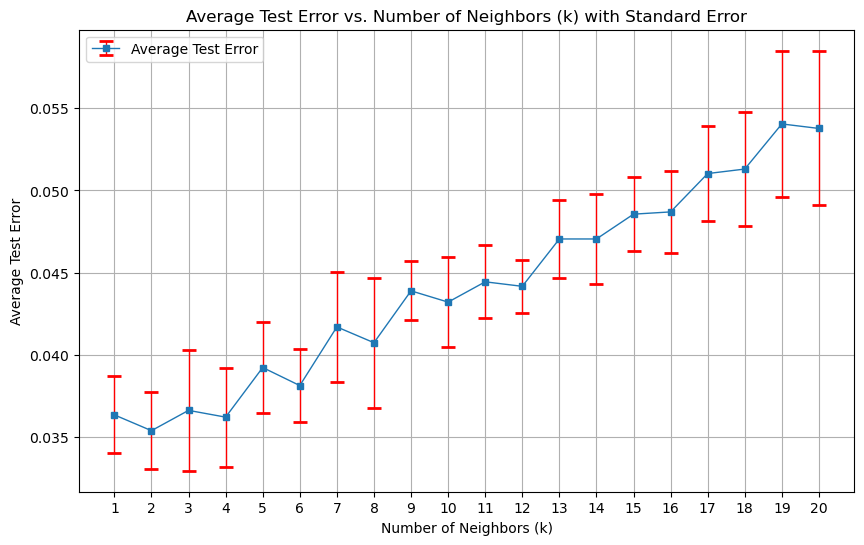

In [3]:
def load_gzipped_data(file_path):
    
    with gzip.open(file_path, 'rt') as file:  # Open the gzipped file in text mode
        # Initialize lists to store labels and features
        labels = []
        features = []
        
        # Process each line in the file
        for line in file:
            
            tokens = line.strip().split()
            labels.append(int(float(tokens[0])))  # First token is the label
            features.append([int(float((value))) for value in tokens[1:]])  # Remaining tokens are features
            
        # Convert lists to numpy arrays and normalize features
        labels = np.array(labels)
        features = np.array(features) / 255.0  # Normalize to [0, 1]
        
    return labels, features

# Load training and testing data
train_labels, train_features = load_gzipped_data('/Users/margokim/Downloads/zip.train.gz')
test_labels, test_features = load_gzipped_data('/Users/margokim/Downloads/zip.test.gz')

def nadaraya_watson_knn(X_train, y_train, X_test, k=5):
    """
    k-NN classification using the Nadaraya-Watson kernel method.
    """
    distances = pairwise_distances(X_test, X_train, metric='euclidean')
    knn_indices = np.argsort(distances, axis=1)[:, :k]
    knn_labels = y_train[knn_indices]
    weights = 1 / (distances[np.arange(distances.shape[0])[:, None], knn_indices] + 1e-5)
    weighted_labels = np.array([np.bincount(labels, weights=weight, minlength=10) for labels, weight in zip(knn_labels, weights)])
    predictions = np.argmax(weighted_labels, axis=1)
    return predictions

def calculate_accuracy(y_true, y_pred):
    
    return np.mean(y_true == y_pred)

predictions = nadaraya_watson_knn(train_features, train_labels, test_features, k=5)
accuracy = calculate_accuracy(test_labels, predictions)

print(f"Model accuracy: {accuracy:.4f}")



def zero_one_loss(y_true, y_pred):
    """
    Compute the zero-one loss function - a simple error count.
    
    Parameters:
    - y_true: Numpy array of true labels
    - y_pred: Numpy array of predicted labels
    
    Returns:
    - loss: Zero-one loss (number of misclassifications)
    """
    return np.sum(y_true != y_pred)

def k_fold_cross_validation_knn(X, y, k_range=range(1, 21), folds=5):
    """
    Estimate the average test error and standard deviation for each 'k' in k-NN using 5-fold cross-validation.
    
    Parameters:
    - X: Features in the dataset
    - y: Labels in the dataset
    - k_range: Range of 'k' values to test
    - folds: Number of folds for cross-validation
    
    Returns:
    - average_errors: Dictionary mapping 'k' to its average zero-one loss and standard deviation across folds
    """
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    average_errors = {k: [] for k in k_range}
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for k in k_range:
            predictions = nadaraya_watson_knn(X_train, y_train, X_test, k=k)
            loss = zero_one_loss(y_test, predictions)
            average_errors[k].append(loss)
    
    # Compute the average zero-one loss and standard deviation for each 'k'
    final_errors = {}
    for k in average_errors:
        mean_loss = np.mean(average_errors[k])
        std_loss = np.std(average_errors[k])
        final_errors[k] = {'average_error': mean_loss / len(y_test), 'std_error': std_loss / len(y_test)}  # Normalize by test set size
    
    return final_errors

# Assuming the k_fold_cross_validation_knn is corrected
average_test_errors = k_fold_cross_validation_knn(train_features, train_labels, k_range=range(1, 21), folds=5)

# Extracting values for plotting
ks = list(average_test_errors.keys())
average_errors = [average_test_errors[k]['average_error'] for k in ks]
std_errors = [average_test_errors[k]['std_error'] for k in ks]

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(ks, average_errors, yerr=std_errors, fmt='-o', capsize=5, capthick=2, ecolor='r', marker='s', markersize=5, linestyle='-', linewidth=1, label='Average Test Error')
plt.title('Average Test Error vs. Number of Neighbors (k) with Standard Error')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Test Error')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()


4. Apply the one-standard error rule to select a final value for 'k'. Apply the One-Standard Error Rule: After estimating the average test error and its standard error for each value of 'k', identify the smallest value of 'k' for which the test error is within one standard error of the lowest test error. This 'k' will be used for the final model.

In [4]:
min_error = min(average_errors)
min_index = average_errors.index(min_error)
min_std_error = std_errors[min_index]

target_error = min_error + min_std_error
best_k = None
for i in range(len(ks)):
    if average_errors[i] <= target_error:
        best_k = ks[i]
        break

print(f"Selected k using the one-standard error rule: {best_k}")

Selected k using the one-standard error rule: 1


5. Fit a final k-NN model using the full training data set and using the selected value for 'k'. Use the entire training dataset and the selected 'k' to fit the k-NN model.

In [7]:
final_predictions = nadaraya_watson_knn(train_features, train_labels, test_features, k=1)

# Calculate accuracy
final_accuracy = calculate_accuracy(test_labels, final_predictions)
print(f"Final Model Accuracy: {final_accuracy:.4f}")


Final Model Accuracy: 0.9382


6. Using the test data set, compute a confusion matrix and an estimate of conditional test error (using the zero-one loss).

Confusion Matrix:
[[354   0   2   0   0   0   1   0   1   1]
 [  0 257   0   0   4   0   2   1   0   0]
 [  6   0 180   1   1   1   0   1   6   2]
 [  4   0   1 146   0  13   0   0   1   1]
 [  0   1   2   0 179   0   2   2   1  13]
 [  3   0   1   3   1 145   1   0   3   3]
 [  1   0   1   0   1   3 163   0   1   0]
 [  0   2   1   1   3   0   0 139   0   1]
 [  4   1   1   6   0   2   0   1 150   1]
 [  1   1   0   0   2   0   0   2   1 170]]
Zero-One Loss: 124
Conditional Test Error: 0.0618


/var/folders/qv/b315g44s20xbflxhcr30rytc0000gn/T/ipykernel_90824/3974703625.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(range(10)))  # Assuming labels from 0-9
/var/folders/qv/b315g44s20xbflxhcr30rytc0000gn/T/ipykernel_90824/3974703625.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(range(10)))  # Assuming labels from 0-9


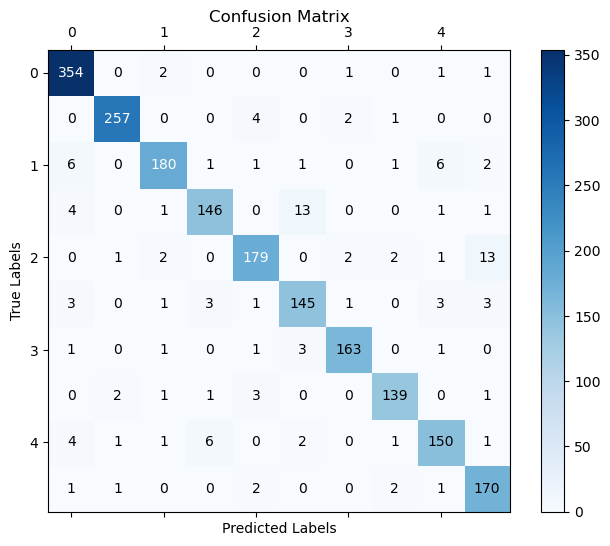

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Example values for demonstration, ensure to define or calculate these before using in the plot
final_predictions = nadaraya_watson_knn(train_features, train_labels, test_features, k=best_k)
final_confusion_matrix = confusion_matrix(test_labels, final_predictions)
final_zero_one_loss = zero_one_loss(test_labels, final_predictions)
conditional_test_error = final_zero_one_loss / len(test_labels)

print("Confusion Matrix:")
print(final_confusion_matrix)
print(f"Zero-One Loss: {final_zero_one_loss}")
print(f"Conditional Test Error: {conditional_test_error:.4f}")

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(final_confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Adding annotations to each cell
for (i, j), val in np.ndenumerate(final_confusion_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black' if final_confusion_matrix[i, j] < (final_confusion_matrix.max() / 2) else 'white')

ax.set_title('Confusion Matrix', pad=20)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticklabels([''] + list(range(10)))  
ax.set_yticklabels([''] + list(range(10))) 
plt.show()
